In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq
import src.advec_diff_case.advec_diff_eqn_LES as les

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy as spy

tf.keras.backend.set_floatx('float32')

## Define some useful classes

### Initial conditions

In [4]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

## Main part starts here

## Solve for high-resolution

In [9]:
app = adeq.ad_eqn_args(T = 2.5, nt = 250, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

u = ddeinttf(adeq.ad_eqn(op), u0, t)

## Solve for low resolution

In [10]:
app_lowres = adeq.ad_eqn_args(T = 2.5, nt = 250, L = 1., nx = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x_lowres = tf.linspace(0., app_lowres.L, app_lowres.nx)
u0_lowres = initial_cond(x_lowres, app_lowres) # Initial conditions
t_lowres = tf.linspace(0., app_lowres.T, app_lowres.nt) # Time array

op_lowres = adeq.operators(app_lowres)

u_lowres = ddeinttf(adeq.ad_eqn(op_lowres), u0_lowres, t_lowres)

## Plots for high resolution solution

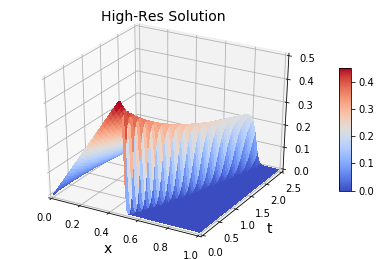

In [40]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('High-Res Solution', fontsize=14)
ax_u.set_xlabel('x', fontsize=14)
ax_u.set_ylabel('t', fontsize=14)
plot = ax_u.plot_surface(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])
ax_u.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

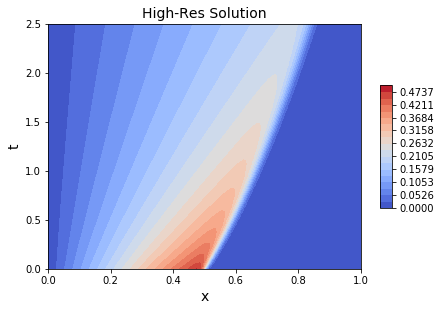

In [60]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u = fig.add_subplot(111)

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('High-Res Solution', fontsize=14)
ax_u.set_xlabel('x', fontsize=14)
ax_u.set_ylabel('t', fontsize=14)
plot = ax_u.contourf(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.5, 20))
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

plt.colorbar(plot, ax=ax_u, shrink=0.5, aspect=10)

fig.show()

## Plots for high-resolution solution interpolated on low-resolution grid

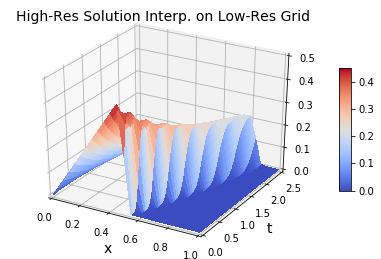

In [41]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_lowres = fig.add_subplot(111, projection='3d')

X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())
f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_lowres.cla()
ax_u_lowres.set_title('High-Res Solution Interp. on Low-Res Grid', fontsize=14)
ax_u_lowres.set_xlabel('x', fontsize=14)
ax_u_lowres.set_ylabel('t', fontsize=14)
plot = ax_u_lowres.plot_surface(X_lowres, T_lowres, f(x_lowres, t_lowres), cmap=plt.get_cmap('coolwarm'),
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_lowres.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_lowres.set_ylim(t_lowres[0], t_lowres[-1])
ax_u_lowres.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

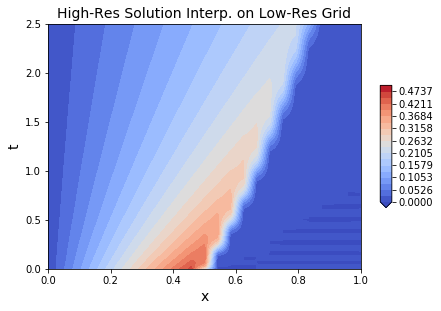

In [61]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_lowres = fig.add_subplot(111)

X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())
f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_lowres.cla()
ax_u_lowres.set_title('High-Res Solution Interp. on Low-Res Grid', fontsize=14)
ax_u_lowres.set_xlabel('x', fontsize=14)
ax_u_lowres.set_ylabel('t', fontsize=14)
plot = ax_u_lowres.contourf(X_lowres, T_lowres, f(x_lowres, t_lowres), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.5, 20), extend='min')
ax_u_lowres.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_lowres.set_ylim(t_lowres[0], t_lowres[-1])

plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

fig.show()

## Plots for low resolution solution

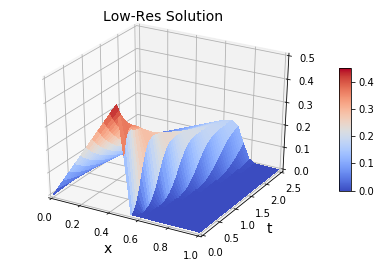

In [42]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_lowres = fig.add_subplot(111, projection='3d')

ax_u_lowres.cla()
ax_u_lowres.set_title('Low-Res Solution', fontsize=14)
ax_u_lowres.set_xlabel('x', fontsize=14)
ax_u_lowres.set_ylabel('t', fontsize=14)
plot = ax_u_lowres.plot_surface(X_lowres, T_lowres, tf.squeeze(u_lowres, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_lowres.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_lowres.set_ylim(t_lowres[0], t_lowres[-1])
ax_u_lowres.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

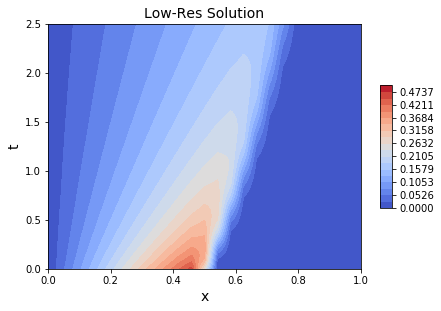

In [62]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_lowres = fig.add_subplot(111)

ax_u_lowres.cla()
ax_u_lowres.set_title('Low-Res Solution', fontsize=14)
ax_u_lowres.set_xlabel('x', fontsize=14)
ax_u_lowres.set_ylabel('t', fontsize=14)
plot = ax_u_lowres.contourf(X_lowres, T_lowres, tf.squeeze(u_lowres, axis=1).numpy(), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.5, 20))
ax_u_lowres.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_lowres.set_ylim(t_lowres[0], t_lowres[-1])

plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

fig.show()

## Difference between high-res solution interp. on low-res grid and high-res solution

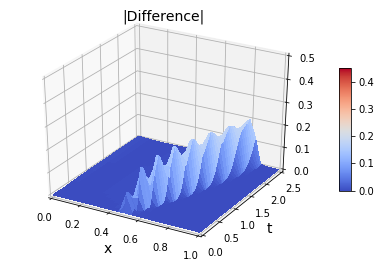

In [70]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_diff = fig.add_subplot(111, projection='3d')

X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_diff.cla()
ax_u_diff.set_title('|Difference|', fontsize=14)
ax_u_diff.set_xlabel('x', fontsize=14)
ax_u_diff.set_ylabel('t', fontsize=14)
plot = ax_u_diff.plot_surface(X_lowres, T_lowres, tf.abs(f(x_lowres, t_lowres) - tf.squeeze(u_lowres, axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_diff.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_diff.set_ylim(t_lowres[0], t_lowres[-1])
ax_u_diff.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

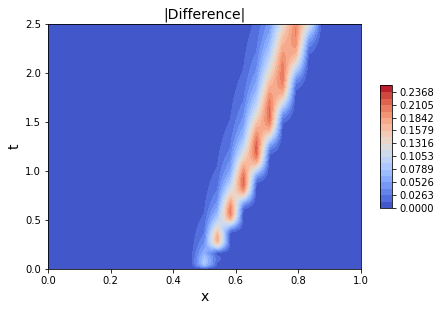

In [65]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_diff = fig.add_subplot(111)

X_lowres, T_lowres = np.meshgrid(x_lowres.numpy(), t_lowres.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_diff.cla()
ax_u_diff.set_title('|Difference|', fontsize=14)
ax_u_diff.set_xlabel('x', fontsize=14)
ax_u_diff.set_ylabel('t', fontsize=14)
plot = ax_u_diff.contourf(X_lowres, T_lowres, tf.abs(f(x_lowres, t_lowres) - tf.squeeze(u_lowres, axis=1)).numpy(), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.25, 20))
ax_u_diff.set_xlim(x_lowres[0], x_lowres[-1])
ax_u_diff.set_ylim(t_lowres[0], t_lowres[-1])

plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

## Solve for the LES model

In [32]:
app_les = les.ad_eqn_args(T = 2.5, nt = 250, L = 1., nx = 25, Re = 1000, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1, Cs = 1.)

x_les = tf.linspace(0., app_les.L, app_les.nx)
u0_les = initial_cond(x_les, app_les) # Initial conditions
t_les = tf.linspace(0., app_les.T, app_les.nt) # Time array

op_les = les.operators(app_les)

u_les = ddeinttf(les.ad_eqn(op_les), u0_les, t_les)

### Plots for Smagorinsky model

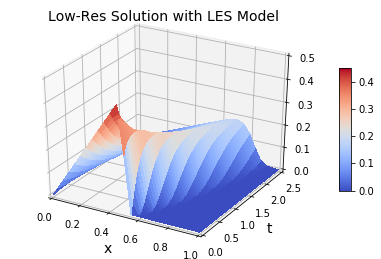

In [44]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_les = fig.add_subplot(111, projection='3d')

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

ax_u_les.cla()
ax_u_les.set_title('Low-Res Solution with LES Model', fontsize=14)
ax_u_les.set_xlabel('x', fontsize=14)
ax_u_les.set_ylabel('t', fontsize=14)
plot = ax_u_les.plot_surface(X_les, T_les, tf.squeeze(u_les, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_les.set_xlim(x_les[0], x_les[-1])
ax_u_les.set_ylim(t_les[0], t_les[-1])
ax_u_les.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_les, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

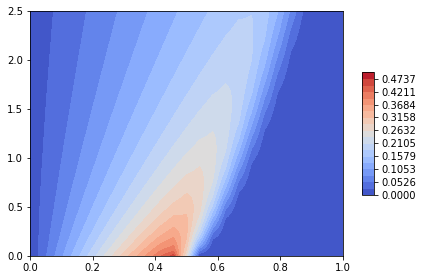

In [67]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_lowres = fig.add_subplot(111)

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

ax_u_les.cla()
ax_u_les.set_title('Low-Res Solution with LES Model', fontsize=14)
ax_u_les.set_xlabel('x', fontsize=14)
ax_u_les.set_ylabel('t', fontsize=14)
plot = ax_u_lowres.contourf(X_les, T_les, tf.squeeze(u_les, axis=1).numpy(), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.5, 20))
ax_u_les.set_xlim(x_les[0], x_les[-1])
ax_u_les.set_ylim(t_les[0], t_les[-1])
ax_u_les.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

fig.show()

## Difference between high-res solution interp on low-res grid and LES model

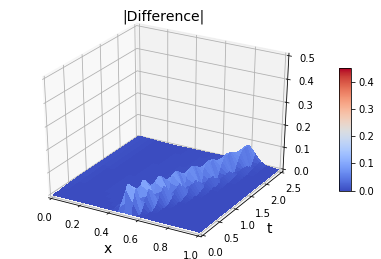

In [71]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_diff = fig.add_subplot(111, projection='3d')

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_diff.cla()
ax_u_diff.set_title('|Difference|', fontsize=14)
ax_u_diff.set_xlabel('x', fontsize=14)
ax_u_diff.set_ylabel('t', fontsize=14)
plot = ax_u_diff.plot_surface(X_les, T_les, tf.abs(f(x_les, t_les) - tf.squeeze(u_les, axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_diff.set_xlim(x_les[0], x_les[-1])
ax_u_diff.set_ylim(t_les[0], t_les[-1])
ax_u_diff.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

#### Contour plot

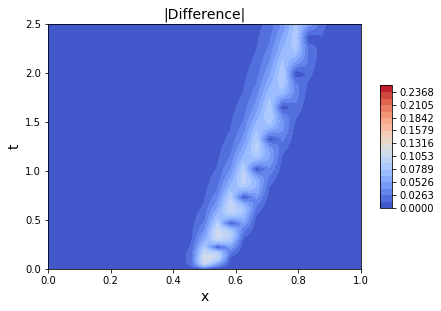

In [66]:
fig = plt.figure(figsize=(7, 4.5), facecolor='white')
ax_u_diff = fig.add_subplot(111)

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_diff.cla()
ax_u_diff.set_title('|Difference|', fontsize=14)
ax_u_diff.set_xlabel('x', fontsize=14)
ax_u_diff.set_ylabel('t', fontsize=14)
plot = ax_u_diff.contourf(X_les, T_les, tf.abs(f(x_les, t_les) - tf.squeeze(u_les, axis=1)).numpy(), cmap=cm.coolwarm,
                     antialiased=False, levels=np.linspace(0, 0.25, 20))
ax_u_diff.set_xlim(x_les[0], x_les[-1])
ax_u_diff.set_ylim(t_les[0], t_les[-1])

plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

### Simultaneously plot LES model and its comparison

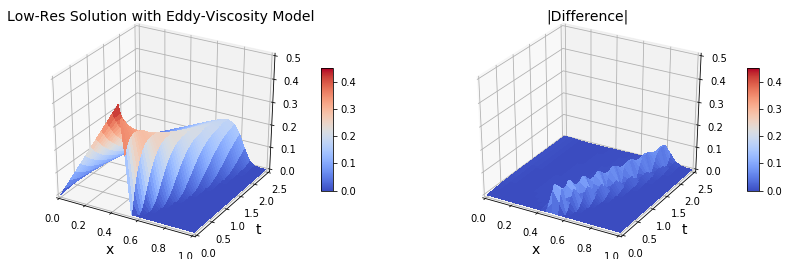

In [72]:
fig = plt.figure(figsize=(14, 4.5), facecolor='white')
ax_u_les = fig.add_subplot(121, projection='3d')
ax_u_diff = fig.add_subplot(122, projection='3d')

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

ax_u_les.cla()
ax_u_les.set_title('Low-Res Solution with Eddy-Viscosity Model', fontsize=14)
ax_u_les.set_xlabel('x', fontsize=14)
ax_u_les.set_ylabel('t', fontsize=14)
plot = ax_u_les.plot_surface(X_les, T_les, tf.squeeze(u_les, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_les.set_xlim(x_les[0], x_les[-1])
ax_u_les.set_ylim(t_les[0], t_les[-1])
ax_u_les.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_les, shrink=0.5, aspect=10)

X_les, T_les = np.meshgrid(x_les.numpy(), t_les.numpy())

f = spy.interpolate.interp2d(x, t, tf.squeeze(u, axis=1).numpy(), kind='cubic')

ax_u_diff.cla()
ax_u_diff.set_title('|Difference|', fontsize=14)
ax_u_diff.set_xlabel('x', fontsize=14)
ax_u_diff.set_ylabel('t', fontsize=14)
plot = ax_u_diff.plot_surface(X_les, T_les, tf.abs(f(x_les, t_les) - tf.squeeze(u_les, axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                    linewidth=0, antialiased=False, vmin=0, vmax=0.45)
ax_u_diff.set_xlim(x_les[0], x_les[-1])
ax_u_diff.set_ylim(t_les[0], t_les[-1])
ax_u_diff.set_zlim(0., 0.5)

plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)

fig.show()

## Compute Errors for the LES model

#### Compute the time-averaged L2 error for the prediction

In [38]:
tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(tf.squeeze(u_les, axis=1), tf.convert_to_tensor(f(x_les, t_les), tf.float32)), axis=-1)), axis=0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.11641116>

#### Compute time-averaged RMSE for points with error above a threshold for prediction

In [112]:
thres = tf.reduce_max(tf.convert_to_tensor(f(x_les, t_les), tf.float32))*0.02
error = []
diff = tf.squeeze(u_les, axis=1) - tf.convert_to_tensor(f(x_les, t_les), tf.float32)

for i in range(1, u_les.shape[0]):
    diff_t = np.abs(np.squeeze(diff[i, :].numpy()))
    error_t = diff_t[np.where(diff_t >= thres)]
    error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
    error.append(error_t)
    
np.mean(np.array(error))

0.05266285740681046

## Compute Errors for the low-res model

#### Compute the time-averaged L2 error for the prediction

In [39]:
tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(tf.squeeze(u_lowres, axis=1), tf.convert_to_tensor(f(x_les, t_les), tf.float32)), axis=-1)), axis=0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21952781>

#### Compute time-averaged RMSE for points with error above a threshold for prediction

In [111]:
thres = tf.reduce_max(tf.convert_to_tensor(f(x_les, t_les), tf.float32))*0.02
error = []
diff = tf.squeeze(u_lowres, axis=1) - tf.convert_to_tensor(f(x_les, t_les), tf.float32)

for i in range(1, u_lowres.shape[0]):
    diff_t = np.abs(np.squeeze(diff[i, :].numpy()))
    error_t = diff_t[np.where(diff_t >= thres)]
#     print(error_t)
    if len(error_t) == 0: continue
    error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
#     print(error_t)
    error.append(error_t)
    
np.mean(np.array(error))

0.10992307132692551